# Final Project :- Rainbow dqn agent

In [2]:
# when ran on colab
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379366 sha256=b3d9f24e07bde381f099274863b74cb6ea1a2b9a8071753e2bc77568d790ab9f
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import gymnasium as gym # type: ignore
import numpy as np # type: ignore
from collections import deque
import random
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import torch.nn.functional as F # type: ignore
import pickle
import time

import matplotlib.pyplot as plt # type: ignore
import cv2 # type: ignore

from collections import deque, namedtuple
import imageio # type: ignore


torch.backends.cudnn.benchmark = True





GAMMA = 0.99
N_STEPS = 3



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

#removed acceleration from steering
#wish I could have tried all possible combinations, training time sucks
ACTIONS = [
    [-1, 0, 0],   
    [1, 0, 0],    
    [0, 1, 0],    
    [0, 0, 0.8],  
    [0, 0, 0],    
]
N_ACTIONS = len(ACTIONS)










## pre-processing and buffer

In [4]:

def preprocess(obs):

    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84,84))
    return resized.astype(np.float32) / 255.0

class frame_stacker:

    def __init__(self, k):
        self.k = k
        self.frames = deque([], maxlen=k)
    def reset(self, obs):
        pre = preprocess(obs)
        for _ in range(self.k):
            self.frames.append(pre)
        return np.stack(self.frames, axis=0)
    def step(self, obs):
        self.frames.append(preprocess(obs))
        return np.stack(self.frames, axis=0)
    

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:

    def __init__(self, capacity, n_steps=1, gamma=0.99):

        self.buffer = deque(maxlen=capacity)
        self.n_step_buffer = deque(maxlen=n_steps)
        self.n_steps = n_steps
        self.gamma = gamma

    def push(self, *args):

        self.n_step_buffer.append(Transition(*args))
        if len(self.n_step_buffer) < self.n_steps:
            return
        reward, next_state, done = self._get_n_step_info()
        state, action = self.n_step_buffer[0].state, self.n_step_buffer[0].action
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def _get_n_step_info(self):

        reward, next_state, done = 0, self.n_step_buffer[-1].next_state, self.n_step_buffer[-1].done
        for idx, transition in enumerate(self.n_step_buffer):
            reward += (self.gamma ** idx) * transition.reward
            if transition.done:
                break
        return reward, next_state, done

    def sample(self, batch_size):

        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.from_numpy(np.array(states)).float().to(DEVICE),
            torch.from_numpy(np.array(actions)).long().unsqueeze(1).to(DEVICE),
            torch.FloatTensor(rewards).unsqueeze(1).to(DEVICE),
            torch.from_numpy(np.array(next_states)).float().to(DEVICE),
            torch.FloatTensor(dones).unsqueeze(1).to(DEVICE)
        )

class dueling_dqn(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )
        self.fc_adv = nn.Sequential(nn.Linear(64 * 7 * 7, 256), nn.ReLU(), nn.Linear(256, n_actions))
        self.fc_val = nn.Sequential(nn.Linear(64 * 7 * 7, 256), nn.ReLU(), nn.Linear(256, 1))

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        adv = self.fc_adv(x)
        val = self.fc_val(x)
        return val + adv - adv.mean(dim=1, keepdim=True)

## defining the agent

In [5]:

class rainbow_dqn:

    def __init__(self):

        self.policy_net = dueling_dqn(N_ACTIONS).to(DEVICE)
        self.target_net = dueling_dqn(N_ACTIONS).to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer(100000, N_STEPS, GAMMA)
        self.epsilon = 1.0
        self.steps = 0

    def select_action(self, state):

        if random.random() < self.epsilon:
            return random.randint(0, N_ACTIONS - 1)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            q_vals = self.policy_net(state_tensor)
            return q_vals.argmax(1).item()

    def update(self):

        if len(self.replay_buffer) < 64:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(64)

        with torch.no_grad():

            next_q = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_val = self.target_net(next_states).gather(1, next_q)
            target = rewards + (1 - dones) * (GAMMA ** N_STEPS) * next_q_val

        q_values = self.policy_net(states).gather(1, actions)
        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % 1000 == 0:

            self.target_net.load_state_dict(self.policy_net.state_dict())

        self.steps += 1


    def train(self, env, episodes= 1000):

        fs = frame_stacker(4)
        reward_log = []

        best_reward = float('-inf')

        for ep in range(episodes):

            obs, info = env.reset()
            state = fs.reset(obs)
            done = False
            total_reward = 0

            while not done:

                action_idx = self.select_action(state)
                action = ACTIONS[action_idx]
                next_obs, reward, terminated, truncated, info = env.step(np.array(action, dtype=np.float32))

                next_state = fs.step(next_obs)
                done = terminated or truncated

                self.replay_buffer.push(state, action_idx, reward, next_state, done)
                self.update()
                state = next_state
                total_reward += reward

            self.epsilon = max(0.05, self.epsilon * 0.995)
            reward_log.append(total_reward)
            print(f"episode {ep} | reward: {total_reward:.2f} | timestamp: {time.strftime('%H:%M:%S')} | epsilon: {self.epsilon:.3f}")

            if total_reward > best_reward:
                best_reward = total_reward
                torch.save(self.policy_net.state_dict(), "rainbow_dqn.pt")

        # torch.save(self.policy_net.state_dict(), "rainbow_dqn.pt")




        return reward_log

### Building agents and training modules

episode 0 | reward: -56.95 | timestamp: 11:36:36 | epsilon: 0.995
episode 1 | reward: -55.39 | timestamp: 11:36:54 | epsilon: 0.990
episode 2 | reward: -48.72 | timestamp: 11:37:11 | epsilon: 0.985
episode 3 | reward: -53.85 | timestamp: 11:37:28 | epsilon: 0.980
episode 4 | reward: -53.90 | timestamp: 11:37:46 | epsilon: 0.975
episode 5 | reward: -42.24 | timestamp: 11:38:03 | epsilon: 0.970
episode 6 | reward: -53.99 | timestamp: 11:38:21 | epsilon: 0.966
episode 7 | reward: -49.32 | timestamp: 11:38:39 | epsilon: 0.961
episode 8 | reward: -50.53 | timestamp: 11:38:56 | epsilon: 0.956
episode 9 | reward: -50.70 | timestamp: 11:39:14 | epsilon: 0.951
episode 10 | reward: -55.27 | timestamp: 11:39:32 | epsilon: 0.946
episode 11 | reward: -52.68 | timestamp: 11:39:50 | epsilon: 0.942
episode 12 | reward: -52.73 | timestamp: 11:40:07 | epsilon: 0.937
episode 13 | reward: -48.98 | timestamp: 11:40:25 | epsilon: 0.932
episode 14 | reward: -46.84 | timestamp: 11:40:43 | epsilon: 0.928
episo

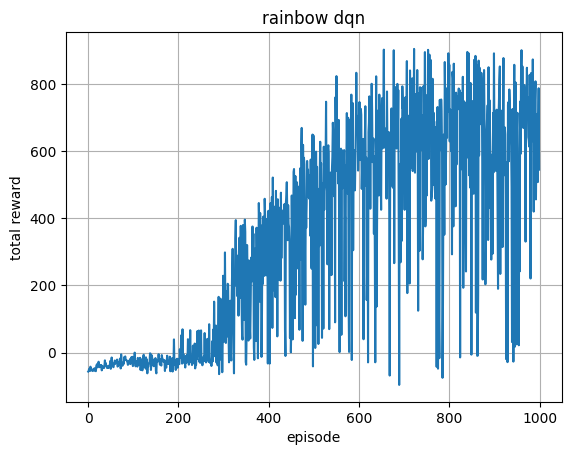

In [3]:
env = gym.make("CarRacing-v3", render_mode=None)
agent = rainbow_dqn()
rewards = agent.train(env)

plt.plot(rewards)
plt.xlabel("episode")
plt.ylabel("total reward")
plt.title("rainbow dqn")
plt.grid(True)
plt.show()


## Evaluate the model


In [39]:
def agent_evaluation(agent, model_path):

    env = gym.make("CarRacing-v3", render_mode='rgb_array')
    fs = frame_stacker(4)

    agent.policy_net.load_state_dict(torch.load(model_path, map_location=DEVICE))
    agent.policy_net.eval()

    episode_rewards = []

    for ep in range(10):
        obs, _ = env.reset()
        state = fs.reset(obs)
        done = False
        total_reward = 0

        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                q_vals = agent.policy_net(state_tensor)
                action_idx = q_vals.argmax(1).item()

            action = ACTIONS[action_idx]
            next_obs, reward, terminated, truncated, _ = env.step(np.array(action, dtype=np.float32))
            done = terminated or truncated

            state = fs.step(next_obs)
            total_reward += reward

        episode_rewards.append(total_reward)
        print(f"episode {ep+1}: reward = {total_reward:.2f}")

    env.close()

    print(f'avg reward : {sum(episode_rewards)/10}')

    plot_rewards(episode_rewards, label="rainbow dqn evaluation")








def plot_rewards(rewards, label):
    
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Reward Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()



/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_47818/2685388719.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load(

episode 1: reward = 841.39
episode 2: reward = 910.40
episode 3: reward = 860.94
episode 4: reward = 878.34
episode 5: reward = 652.44
episode 6: reward = 741.58
episode 7: reward = 874.64
episode 8: reward = 631.88
episode 9: reward = 492.47
episode 10: reward = 730.30
avg reward : 761.4386469588951


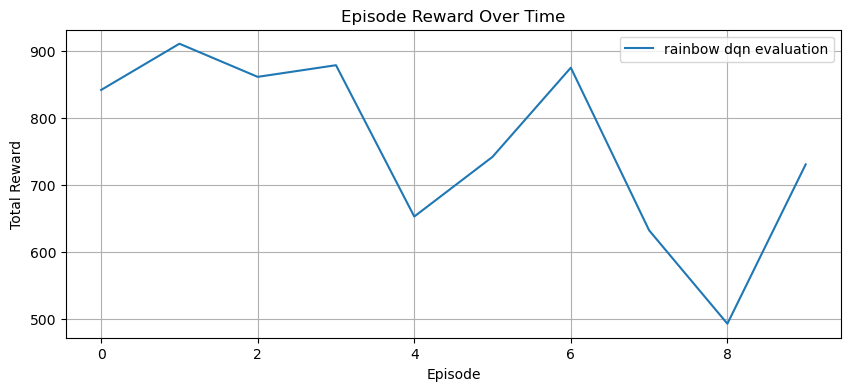

In [40]:

agent_evaluation(rainbow_dqn(), "rainbow_dqn.pt")

## module to save the single run

In [31]:
def record_episode(agent, model_path, filename="rainbow_episode.mp4"):


    env = gym.make("CarRacing-v3", render_mode="rgb_array")

    fs = frame_stacker(4)

    agent.policy_net.load_state_dict(torch.load(model_path, map_location=DEVICE))
    agent.policy_net.eval()



    obs, _ = env.reset()
    state = fs.reset(obs)

    frames = []
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            q_vals = agent.policy_net(state_tensor)
            action_idx = q_vals.argmax(1).item()

        action = ACTIONS[action_idx]
        next_obs, reward, terminated, truncated, _ = env.step(np.array(action, dtype=np.float32))
        frames.append(env.render())
        done = terminated or truncated

        state = fs.step(next_obs)
        total_reward += reward

    env.close()
    imageio.mimsave(filename, frames, fps=30)
    print(f'reward: {total_reward}')


## final agent

In [32]:
agent = rainbow_dqn()
agent.policy_net.load_state_dict(torch.load("rainbow_dqn.pt", map_location=DEVICE))
agent.policy_net.eval()

record_episode(agent, "rainbow_dqn.pt")


/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_47818/1405467449.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load("

reward: 731.0344827586039


## agent after fewer episodes

In [8]:
agent = rainbow_dqn()


record_episode(agent, model_path= "rainbow_dqn_first_checkpoint.pt", filename= " first_checkpoint_episode.mp4")


/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_47818/3611120161.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load(

reward: 590.3225806451526


## agent after more episodes

In [9]:
agent = rainbow_dqn()


record_episode(agent, model_path= "rainbow_dqn_second_checkpoint.pt", filename= " second_checkpoint_episode.mp4")


/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_47818/3611120161.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load(

reward: 892.4242424242243


### module to evaulate trained agent